In [1]:
include("TontiDiagrams.jl")
using .Tonti
using CombinatorialSpaces
using DifferentialEquations
using AlgebraicPetri
using CairoMakie

AbstractPlotting.inline!(true)

In [2]:
function plot_heatmap(values, width, height, ind::Function; crange=(0.0,0.0))
    equ_h = sqrt(3)/2
    vertices = Array{Real}(undef, 0, 2)
    faces = Array{Int}(undef, 0, 3)
    colors = Array{Real}(undef, 0)
    for h in 1:height - 1
        for w in 1:width - 1
            faces = vcat(faces, [1 2 3; 4 5 6] .+ length(faces))
            if h % 2 == 1
                append!(colors, vcat([values[ind(w, h)],values[ind(w+1, h)],values[ind(w, h+1)]],
                                     [values[ind(w+1, h+1)],values[ind(w+1, h)],values[ind(w, h+1)]]))
                vertices = vcat(vertices, [w-1 (h-1)*equ_h; w (h-1)*equ_h; w-0.5 h*equ_h])
                vertices = vcat(vertices, [w+0.5 h*equ_h; w (h-1)*equ_h; w-0.5 h*equ_h])
            else
                append!(colors, vcat([values[ind(w, h+1)],values[ind(w+1, h+1)],values[ind(w, h)]],
                                     [values[ind(w+1, h)],values[ind(w+1, h+1)],values[ind(w, h)]]))
                vertices = vcat(vertices, [w-1 h*equ_h; w h*equ_h; w-0.5 (h-1)*equ_h])
                vertices = vcat(vertices, [w+0.5 (h-1)*equ_h; w h*equ_h; w-0.5 (h-1)*equ_h])
            end
        end
    end

    if crange == (0,0)
        println("Reseting crange")
        crange = (minimum(values),maximum(values))
    end
    fig, axis, scatter_thing = mesh(vertices, faces, color = colors, shading = false, colorrange=crange)
    xlims!(axis, [0,width+0.5])
    ylims!(axis, [0,height*equ_h])
    axis.aspect = AxisAspect(1/equ_h)
    fig, axis, scatter_thing
end

function make_colors(values,width, height, ind)
    colors = Array{Real}(undef, 0)
    for h in 1:height - 1
        for w in 1:width - 1
            if h % 2 == 1
                append!(colors, vcat([values[ind(w, h)],values[ind(w+1, h)],values[ind(w, h+1)]],
                                     [values[ind(w+1, h+1)],values[ind(w+1, h)],values[ind(w, h+1)]]))
            else
                append!(colors, vcat([values[ind(w, h+1)],values[ind(w+1, h+1)],values[ind(w, h)]],
                                     [values[ind(w+1, h)],values[ind(w+1, h+1)],values[ind(w, h)]]))
            end
        end
    end
    colors
end

function plot_heatmap(values, width, height, ind::Function; crange=(0.0,0.0), ax::Union{Axis, Nothing}=nothing)
    equ_h = sqrt(3)/2
    vertices = Array{Real}(undef, 0, 2)
    faces = Array{Int}(undef, 0, 3)
    colors = Array{Real}(undef, 0)
    colors = make_colors(values, width, height, ind)
    for h in 1:height-1
        for w in 1:width-1
            faces = vcat(faces, [1 2 3; 4 5 6] .+ length(faces))
            if h % 2 == 1
                vertices = vcat(vertices, [w-1 (h-1)*equ_h; w (h-1)*equ_h; w-0.5 h*equ_h])
                vertices = vcat(vertices, [w+0.5 h*equ_h; w (h-1)*equ_h; w-0.5 h*equ_h])
            else
                vertices = vcat(vertices, [w-1 h*equ_h; w h*equ_h; w-0.5 (h-1)*equ_h])
                vertices = vcat(vertices, [w+0.5 (h-1)*equ_h; w h*equ_h; w-0.5 (h-1)*equ_h])
            end
        end
    end

    if crange == (0,0)
        crange = (minimum(values),maximum(values))
    end
    if isnothing(ax)
        fig, axis, scatter_thing = mesh(vertices, faces, color = colors, shading = false, colorrange=crange)
        xlims!(axis, [0,width+0.5])
        ylims!(axis, [0,height*equ_h])
        axis.aspect = AxisAspect(1/equ_h)
        return fig, axis, scatter_thing
    else
        mesh_ob = mesh!(ax, vertices, faces, color = colors, shading = false, colorrange=crange)
        xlims!(ax, [0,width+0.5])
        ylims!(ax, [0,height*equ_h])
        ax.aspect = AxisAspect(1/equ_h)
        mesh_ob
    end
end


plot_heatmap (generic function with 1 method)

## Define the Tonti Diagram

In [3]:
tda = TontiDiagram(2, [:Ca =>:IP,  :δCa =>:TP,  :ΔCa=>:IL,
                       :∑ϕa=>:TS2, :ϕa=>:TL2]);

## Define the complex

In [4]:
width = 20
height = 20
num_oscillators = width*height

s = OrientedSimplicialSet2D{Bool}()
add_vertices!(s, num_oscillators)

ind(x,y) = x + (y-1)*(width)
tri_ind(x,y) = x + (y-1)*(width-1)*2

for y in 1:(height-1)
    for x in 1:(width-1)
        if y % 2 == 1
            glue_sorted_triangle!(s, ind(x,y), ind(x+1,y), ind(x,y+1), tri_orientation = false)
            glue_sorted_triangle!(s, ind(x+1,y+1), ind(x,y+1), ind(x+1,y), tri_orientation = true)
        else
            glue_sorted_triangle!(s, ind(x+1,y+1), ind(x,y+1), ind(x,y), tri_orientation = true)
            glue_sorted_triangle!(s, ind(x,y), ind(x+1,y+1), ind(x+1,y), tri_orientation = false)
        end
    end
end

addSpace!(tda, s)
addTime!(tda)

## Add the physics

In [5]:
k = -0.3 # Diffusion
dt = 0.1
dx0 = 1.5
dy0 = 1.5

addTransform!(tda, [:ΔCa], ΔC->k*ΔC, [:ϕa])
addTransform!(tda, [:∑ϕa], ∑ϕ->∑ϕ, [:δCa]);

## Generate vectorfield

In [6]:
sim, data_syms = Tonti.vectorfield(tda, s)
data_syms

1-element Array{Pair{Symbol,Int64},1}:
 :Ca => 400

## 2D Diffusion

In [7]:
data_length = [data_syms[k][2] for k in keys(data_syms)]
du = zeros(sum(data_length))
u = [zeros(l) for l in data_length]

for y in 1:height
    for x in 1:width
        u[1][ind(x,y)] = (x/width-(x/width)^2)+(y/height-(y/height)^2)
    end
end

prob = ODEProblem(sim, vcat(u...), (0,1000.0))
sol = solve(prob);

In [8]:
figure, axis, scatter_plot = plot_heatmap(sol(100), width, height, ind, crange=(minimum(sol), maximum(sol)))

framerate = 30
i_range = collect(1:1000)

record(figure, "color_animation.gif", i_range; framerate = framerate) do i
    scatter_plot.color = make_colors(sol(i), width, height, ind)
end

"color_animation.gif"

## 2D Diffusion w/ multiple chemical species

In [9]:
tdb = TontiDiagram(2, [:Cb =>:IP,  :δCb =>:TP,  :ΔCb=>:IL,
                       :∑ϕb=>:TS2, :ϕb=>:TL2]);
tdc = TontiDiagram(2, [:Cc =>:IP,  :δCc =>:TP,  :ΔCc=>:IL,
                       :∑ϕc=>:TS2, :ϕc=>:TL2]);

addTransform!(tdb, [:ΔCb], ΔC->k*ΔC, [:ϕb])
addTransform!(tdb, [:∑ϕb], ∑ϕ->∑ϕ, [:δCb]);
addTransform!(tdc, [:ΔCc], ΔC->k*ΔC, [:ϕc])
addTransform!(tdc, [:∑ϕc], ∑ϕ->∑ϕ, [:δCc]);
addSpace!(tdb, s)
addTime!(tdb)
addSpace!(tdc, s)
addTime!(tdc)

tdab = disj_union(tda, tdb)
td = disj_union(tdab, tdc);

In [10]:
f = AlgebraicPetri.vectorfield(PetriNet(3,(1,3)=>(2,3)))
temp_du = zeros(3)
chemistry(u) = begin
    f(temp_du, u, [0.05], 1)
    temp_du
end
addTransform!(td, [:Ca, :Cb, :Cc], chemistry, [:δCa, :δCb, :δCc]);

In [11]:
sim, data_syms = Tonti.vectorfield(td, s)
data_syms

3-element Array{Pair{Symbol,Int64},1}:
 :Ca => 400
 :Cb => 400
 :Cc => 400

In [12]:
data_length = [data_syms[k][2] for k in keys(data_syms)]
du = zeros(sum(data_length))
u = [zeros(l) for l in data_length]

for y in 1:height
    for x in 1:width
        if x < width/2
            u[1][ind(x,y)] = (x/width-(x/width)^2)+(y/height-(y/height)^2)
        else
            u[3][ind(x,y)] = (x/width-(x/width)^2)+(y/height-(y/height)^2)
        end
    end
end

prob = ODEProblem(sim, vcat(u...), (0,100.0))
sol = solve(prob);

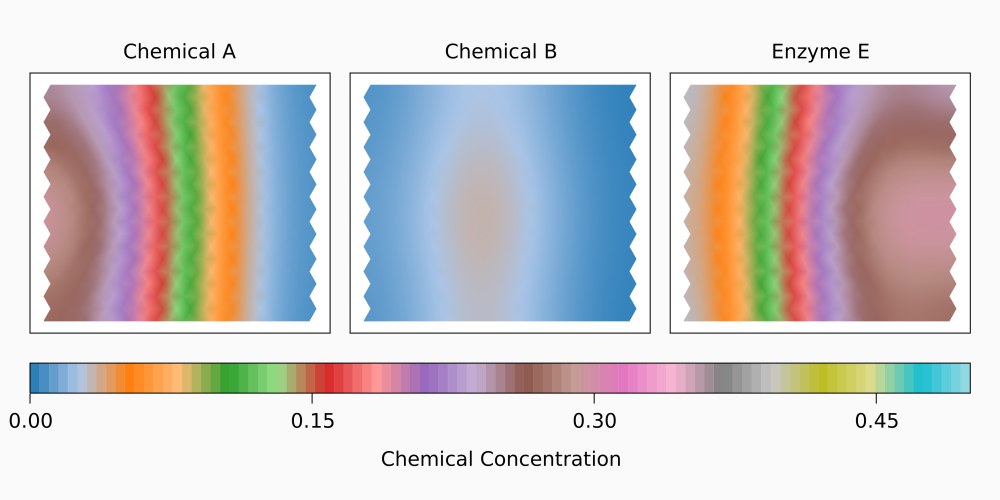

In [13]:
fig = Figure(resolution = (1000, 500), backgroundcolor = RGBf0(0.98, 0.98, 0.98))
crange = (minimum(sol), maximum(sol))
i = 30
axA = fig[1, 1] = Axis(fig, title = "Chemical A")
plA = plot_heatmap(sol(i)[1:num_oscillators], width, height, ind, crange=crange, ax=axA)
axB = fig[1, 2] = Axis(fig, title = "Chemical B")
plB = plot_heatmap(sol(i)[(1:num_oscillators) .+ num_oscillators], width, height, ind, crange=crange, ax=axB)
axE = fig[1, 3] = Axis(fig, title = "Enzyme E")
plE = plot_heatmap(sol(i)[(1:num_oscillators) .+ (2*num_oscillators)], width, height, ind, crange=crange, ax=axE)
linkaxes!(axA, axB, axE)
hidedecorations!.([axA,axB,axE])

cbar = fig[2,1:3] = Colorbar(fig, plA, label = "Chemical Concentration", vertical = false, flipaxisposition = false,
    ticklabelalign = (:center, :top))
cbar.height=30
plA.colormap=:tab20
plB.colormap=:tab20
plE.colormap=:tab20
fig